In [52]:
%matplotlib inline
%run support.py
import os
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')
#datafolder = "./data/Measurements/Cooldown20200826"
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d
from pathlib import Path
from datetime import datetime, timedelta

<Figure size 432x288 with 0 Axes>

(201,) (21001,)


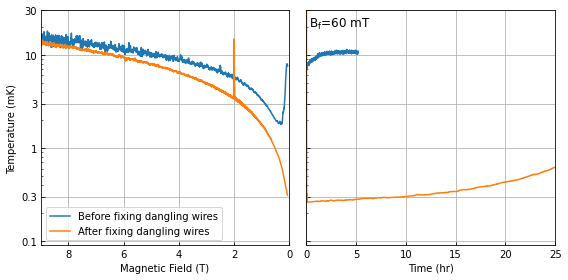

In [150]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

# Before fixing dangling wires
gT = 0.302*2/Rk
Ec = 1.51986/2
datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown38"
filename = f"d304_time.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    t = np.array(f['x_array'])
    g = np.array(f['GcbtlowEc'])*2/Rk
    print(t.shape, g.shape)
    b = np.array(f['bzIPSB'])
    logs = json.loads(f['metadata'].attrs['sweep_logs'])
    time_started = datetime.strptime(logs['time_started'], '%d/%m/%Y %H:%M:%S')
    time_completed = datetime.strptime(logs['time_completed'], '%d/%m/%Y %H:%M:%S')
    last_index = np.where(np.logical_not(np.isnan(g)))[0][-1]
    t = np.linspace(time_started.timestamp(), time_completed.timestamp(), last_index+1)
    
t = t[0:t.shape[0]] - t[0]
g = g[0:t.shape[0]]
b = b[0:t.shape[0]]
g = 1/(1/g-2*R_wire)
g = MakeSmoothie(g)
Tcbt = Tcbt_Cu(g/gT, Ec=Ec)

demag_filter = b>0.060
warmup_filter = b<=0.06001
t0 = t[warmup_filter][0]
t -= t0
ax[0].plot(b[demag_filter], Tcbt[demag_filter], color=colors[0], label="Before fixing dangling wires")
ax[1].plot(t[warmup_filter]/3600, Tcbt[warmup_filter], color=colors[0], label="Before fixing dangling wires")

# After fixing dangling wires
datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826"
with h5py.File(f"{datafolder}/d524_time.h5", "r") as f:
    t = np.array(f['x_array'])
    gCu = np.array(f['gCu'])
    b = np.array(f['bdemagIPSB'])

gCu = 1/(1/gCu - 2*R_wire)
gCu = MakeSmoothie(gCu)
Tcbt = Tcbt_Cu(gCu/gT_Cu, Ec=Ec_Cu)

demag_filter = np.logical_and(b>0.068, Tcbt<20)
warmup_filter = b<=0.06001
t0 = t[warmup_filter][0]
t -= t0
ax[0].plot(b[demag_filter], Tcbt[demag_filter], color=colors[1], label="After fixing dangling wires")
ax[1].plot(t[warmup_filter]/3600, Tcbt[warmup_filter], color=colors[1], label="After fixing dangling wires")

for fn in [526, 527]:
    with h5py.File(f"{datafolder}/d{fn}_time_c12.h5", "r") as f:
        t = np.array(f['x_array'])
        v = np.array(f['x_array'])
        gCu = np.array(f['gCu'])
    t -= t0
    gCu = 1/(1/gCu - 2*R_wire)
    gCu = np.mean(gCu[int(gCu.shape[0]/2)-3:int(gCu.shape[0]/2)+3,:], axis=0)
    gCu = MakeSmoothie(gCu)
    Tcbt = Tcbt_Cu(gCu/gT_Cu, Ec=Ec_Cu)
    
    ax[1].plot(t/3600, Tcbt, color=colors[1])

for i in range(2):
    ax[i].set_ylim(9e-2, 2e1)
    ax[i].grid()
    ax[i].set_yscale('log')
    ax[i].set_yticks([0.1, 0.3, 1, 3, 10, 30])
    ax[i].set_yticklabels([0.1, 0.3, 1, 3, 10, 30])

ax[0].set_ylabel("Temperature (mK)")
ax[0].legend()
ax[0].set_xlabel("Magnetic Field (T)")
ax[1].set_xlabel("Time (hr)")
ax[1].text(0.3, 20, r"$\mathrm{B_f}$=60 mT", fontsize=12)
ax[1].set_yticklabels([])

ax[0].set_xlim(9, 0.0)
ax[1].set_xlim(0, 25)

fig.savefig('FixDanglingWires.pdf')

# High field thermometry is possible

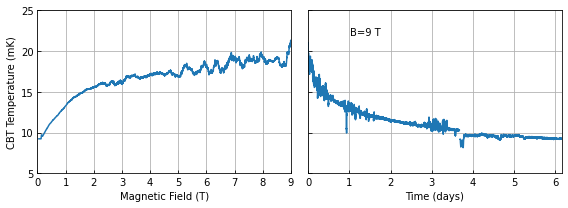

In [184]:
datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826"
gT_Cu = 21.683533093853708e-6
precool_wavenums = [634, 635]
fig, ax = plt.subplots(1,2,figsize=(8,3))

for i, wn in enumerate(precool_wavenums):
    filename = f"d{wn}_time.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        #dt = np.array([datetime.fromtimestamp(t[i]) for i in range(len(t))])
        gCu = np.array(f['gCu'])
        b = np.array(f['bdemagIPSB'])
        #print(f['metadata'].attrs['sweep_logs'])
    gCu = 1/(1/gCu - 2*R_wire)
    gCu = MakeSmoothie(gCu, ws=150)
    if i==0:
        t0=t[0]
        ti = t[b<9][-1]
    if i==len(precool_wavenums)-1:
        tf = t[-1]

    mag_filter = b<9
    precool_filter = b>=8.99
        
    ax[0].plot(b[mag_filter], Tcbt_Cu(gCu[mag_filter]/gT_Cu, Ec=Ec_Cu*1e-3)*1e3, color=colors[0])
    ax[1].plot((t[precool_filter]-ti)/3600/24, Tcbt_Cu(gCu[precool_filter]/gT_Cu, Ec=Ec_Cu*1e-3)*1e3, color=colors[0])
    
#Tmc = GetBFData(6, t0, t[-1])
#Tmc[:,1] = MakeSmoothie(Tmc[:,1], ws=50)
#t_mc = [datetime.fromtimestamp(Tmc[i,0]) for i in range(len(Tmc))]
#ax.plot(t_mc, Tmc[:,1]*1e3, color=colors[1], label=r'$\mathrm{T_{mc}}$')

for i in range(2):
    ax[i].set_ylim(5,30)
    ax[i].grid()
    ax[i].set_ylim(5,25)
    ax[i].set_yticks(np.linspace(5,25,5))
    
#ax.set_yscale('log')
ax[0].set_xlabel("Magnetic Field (T)")
ax[0].set_ylabel("CBT Temperature (mK)")
ax[0].set_xticks(np.arange(0,10,1))
ax[0].set_xlim(0,9)
ax[1].set_xlim(0,(tf-ti)/3600/24)
ax[1].set_yticklabels([])
ax[1].set_xlabel("Time (days)")
ax[1].text(1.02, 22, "B=9 T")

#ax[1].tick_params(axis='x', rotation=45)
fig.savefig("HighFieldThermometry.pdf")